# Airborne MT forward modelling and inversion notebook V0.3

Note: this notebook can be modified to do qamt or controlled source. TODO

In [1]:
# import SimPEG.dask as simpeg
from SimPEG import maps, utils, data, optimization, maps, regularization, inverse_problem, directives, inversion, data_misfit
import discretize
from discretize.utils import mkvc, refine_tree_xyz
from SimPEG.electromagnetics import natural_source as ns
import numpy as np
from scipy.spatial import cKDTree
import matplotlib.pyplot as plt
from pymatsolver import Pardiso as Solver


## Loading the simulation

Load the *.msh file and *.mod file which are UBC formatted. We can extract the active cells by searching for the value used to indicate air cells on line 10 of the following cell

A histogram of the model is generated to get an idea of how many units are present

c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\mixins\mesh_io.py:594: FutureWarning: TensorMesh.readUBC has been deprecated and will be removed indiscretize 1.0.0. please use TensorMesh.read_UBC
  warnings.warn(
c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.readModelUBC has been deprecated, please use TreeMesh.read_model_UBC. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


(54504,) 54504 34840


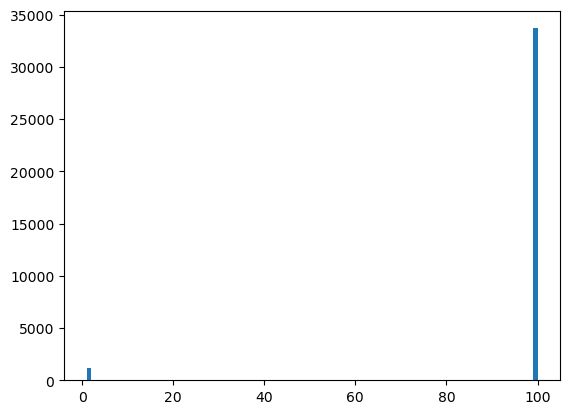

0.01 1.0


In [2]:
# let import the mesh in UBC format
mesh_file = r".\octree_mesh\octree_mesh.txt"
mesh = discretize.TreeMesh.readUBC(mesh_file)

# load the conductivity model
conductivity_file = r".\octree_model\octree_model.con"
model = discretize.TreeMesh.readModelUBC(mesh, conductivity_file)

# extract the acive files
active = model > 1e-8

# model[model == -1] = 50

print(model.shape, mesh.nC, active.sum())

plt.hist(1 / model[active], 100)
plt.show()

print(model[active].min(), model[active].max())


## Load the receiver stations array

Simply load in a CSV file with utm easting, northing and elevation.

receiver numbers: (169, 3)


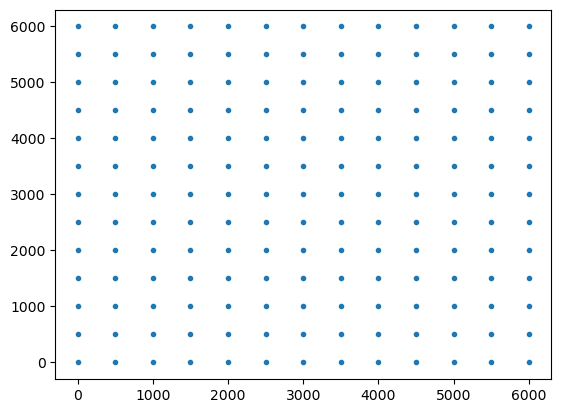

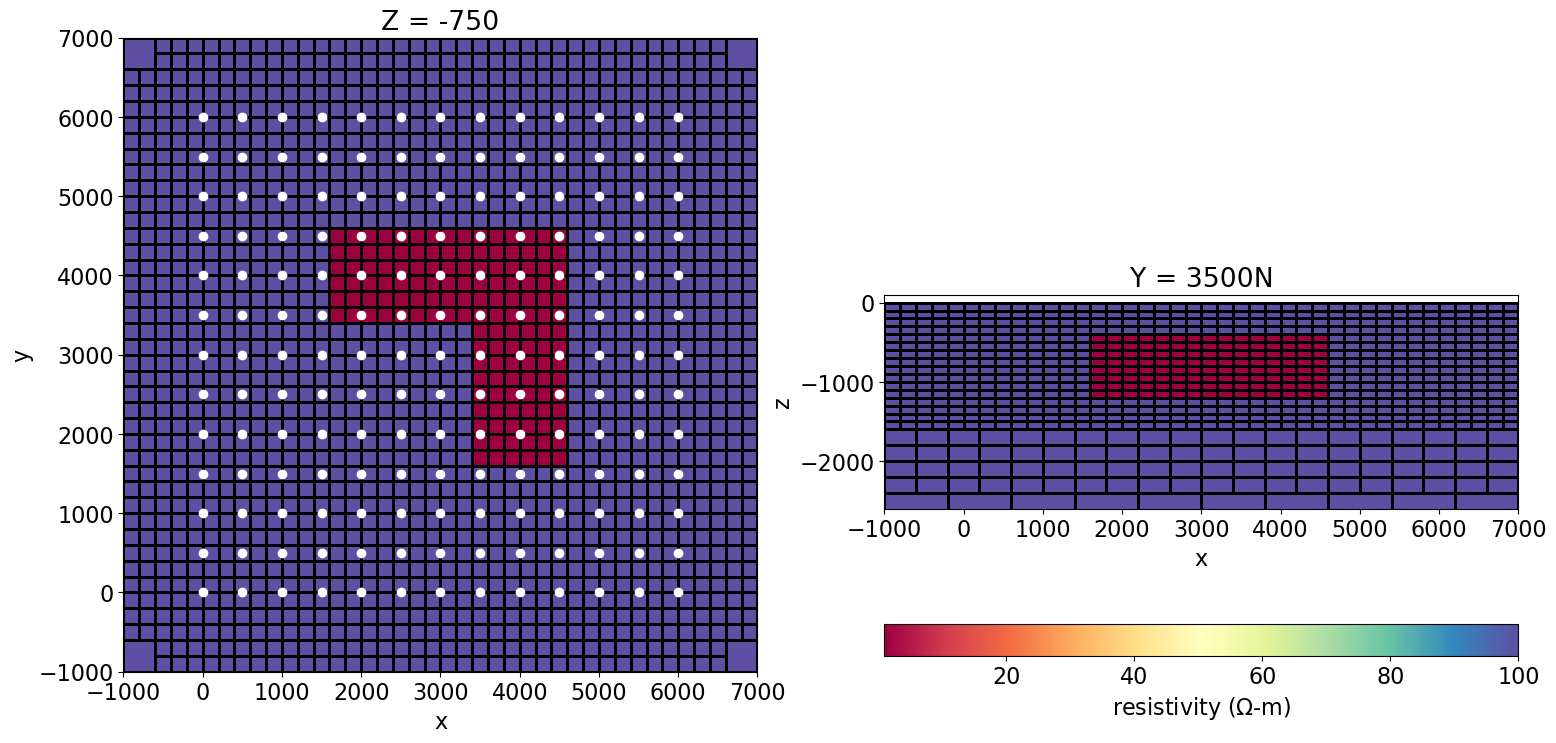

(array([200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200.]), array([200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,
       200., 200., 200., 200., 200., 200., 200., 200., 200., 200., 200.,

In [3]:
import matplotlib
# create receivers
rx_x, rx_y = np.meshgrid(np.arange(0, 6500, 500), np.arange(0, 6500, 500))
receivers = np.hstack((mkvc(rx_x, 2), mkvc(rx_y, 2), np.ones((np.prod(rx_x.shape), 1))*50.0))
print(f"receiver numbers: {receivers.shape}")

plt.plot(receivers[:, 0], receivers[:, 1], '.')
plt.show()


# ---------------------------------------------------------------------------------------------------------------------------------------

# Plot input model

#
font = {'size'   : 16}
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('font', **font)

plt_model = 1 / model
plt_model[~active] = np.nan

fig, ax = plt.subplots(1, 2, figsize=(18, 10))

collect_obj = mesh.plot_slice(plt_model, ax=ax[0], ind=int(120), grid=True, normal='Z', clim=[1, 100], pcolor_opts={"cmap": 'Spectral'})
# color_bar = plt.colorbar(collect_obj[0])
# ax[0].plot(source_locations[:, 0], source_locations[:, 1], '-g', linewidth=6)
# ax[0].text(300, -250, 'Transmiter', fontsize=20, color='white', fontweight='bold')

ax[0].set_xlim([-1000, 7000])
ax[0].set_ylim([-1000, 7000])
ax[0].set_aspect('equal')
ax[0].set_title('Z = -750')
ax[0].plot(receivers[:, 0], receivers[:, 1], 'ow')
# ax[0].axis('equal')
collect_obj = mesh.plot_slice(plt_model, ax=ax[1], ind=int(66), grid=True, normal='Y', clim=[1, 100], pcolor_opts={"cmap": 'Spectral'})
# color_bar = plt.colorbar(collect_obj[0])
ax[1].set_xlim([-1000, 7000])
ax[1].set_ylim([-2600, 100])
ax[1].set_aspect('equal')
ax[1].set_title('Y = 3500N')
fig.colorbar(collect_obj[0], label=r'resistivity ($\Omega$-m)', orientation='horizontal')
plt.show()

print(mesh.h)


## Load up UBC data

In [4]:
ubc_read = np.genfromtxt(r".\data_input\FWDdata.txt")

frequencies = [10, 50, 200]
# organise data by frequency index
ubc_dat = {}

for ii in range(len(frequencies)):

    ubc_dat[ii] = {

        'tzxr': [],
        'tzxi': [],
        'tzyr': [],
        'tzyi': [],
    }

fcnt = 0
findx = 0

for ii in range(ubc_read.shape[0]):

    if len(ubc_read[ii, :]) > 1:

        if fcnt == 169:

            fcnt = 0
            findx += 1

            ubc_dat[findx]['tzxr'] += [ubc_read[ii, 5]]
            ubc_dat[findx]["tzxi"] += [-ubc_read[ii, 6]]
            ubc_dat[findx]['tzyr'] += [ubc_read[ii, 3]]
            ubc_dat[findx]["tzyi"] += [-ubc_read[ii, 4]]

        else:

            ubc_dat[findx]['tzxr'] += [ubc_read[ii, 5]]
            ubc_dat[findx]["tzxi"] += [-ubc_read[ii, 6]]
            ubc_dat[findx]['tzyr'] += [ubc_read[ii, 3]]
            ubc_dat[findx]["tzyi"] += [-ubc_read[ii, 4]]

        fcnt += 1

# print(len(ubc_dat[findx - 1]['tzxr']))

# now create a vectore similar to dobs in simpeg
ubc_obs = []

for ii in range(3):

    ubc_obs += ubc_dat[ii]['tzxr']
    ubc_obs += ubc_dat[ii]['tzxi']
    ubc_obs += ubc_dat[ii]['tzyr']
    ubc_obs += ubc_dat[ii]['tzyi']

print(np.array(ubc_obs).shape)
ubc_obs = np.array(ubc_obs)

(2028,)


## Setting up the simulation

Here the background is set to the median of the model provided. This may or may not need to be adjusted depedning on the experiment.

The simpeg framework is now incorporated by defining the receiver type and components. This can be modified for impedance data or tipper. For tipper data replace the receiver simpeg object type with: `Point3DTipper(receivers, orientation=rx_orientation, component='real')` and `Point3DTipper(receivers, orientation=rx_orientation, component='imag')` on starting on line 12 and 17.

The model slice is also generated to confirm simulated targets.

In [5]:
# set frequencies
freqs = ['10', '50', '200']

background = 100 # np.median(model[active])
# create background conductivity model
sigBG = np.zeros(mesh.nC) + 1 / background
sigBG[~active] = 1e-8

# Make a receiver list
rx_list = []
for rx_orientation in ['zx', 'zy']:
    
    rx_list.append(
        
        ns.receivers.Point3DTipper(receivers,
                                   orientation=rx_orientation,
                                   component='real'
        )
    )
    rx_list.append(

        ns.receivers.Point3DTipper(receivers,
                                   orientation=rx_orientation,
                                   component='imag'
        )
    )

# Source list
src_list = [ns.sources.PlanewaveXYPrimary(rx_list, frequency=float(f)) for f in freqs]

# Survey MT
survey = ns.Survey(src_list)
# survey.drape_topography(mesh, active, option='top')                       # drape topo

# plot the mesh
model_plot = model.copy()
model_plot[~active] = np.nan
ind_slice = int(20)
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
mesh.plotSlice(model_plot, normal="X", ax=ax, ind=ind_slice, grid=True)
ax.axis("equal")


c:\Users\johnk\Anaconda3\envs\jresearch\lib\site-packages\discretize\utils\code_utils.py:217: FutureWarning: TreeMesh.plotSlice has been deprecated, please use TreeMesh.plot_slice. It will be removed in version 1.0.0 of discretize.
  warnings.warn(


(-9800.0, 15800.0, -12800.0, 12800.0)

## Running the forward simulation

Here simpeg map and simulation objects are created which are then used to calculate the forward data using the geological model imported in UBC format.

In [6]:

# Set the mapping
actMap = maps.InjectActiveCells(
    mesh=mesh, indActive=active, valInactive=np.log(1e-8)
)
mapping = maps.ExpMap(mesh) * actMap

# Setup the problem object
sim = ns.simulation.Simulation3DPrimarySecondary(
    
    mesh,
    survey=survey,
    sigmaMap=mapping,
    sigmaPrimary=sigBG,
    solver=Solver

)

sim.model = sigBG[active]

# -------------------------------------------------------------

# calculate the fields

#

import time
source_list = src_list
models = {

    "L_block": np.log(model[active]),
    "half_space": np.log(sigBG[active])
}

fields = {}

for key, sig in models.items():
    if key not in fields.keys(): 
        print(f"starting {key}")
        t = time.time()
        fields[key] = sim.fields(sig)
        print(f"done {key}... elapsed time: {time.time()-t:1.1e}s \n")

sim.survey.dtrue = sim.dpred(np.log(model[active]), f=fields["L_block"])
# create observations
sim.survey.dobs = sim.survey.dtrue


starting L_block
done L_block... elapsed time: 2.2e+02s 

starting half_space
done half_space... elapsed time: 2.1e+02s 



## Plotting the simulation data

Line 11 and 20 will need to be adjusted accoringly depending on the data being observed.

[-0.00064783  0.00027391  0.00191354 ... -0.0002825  -0.00022549
 -0.00013932]
169


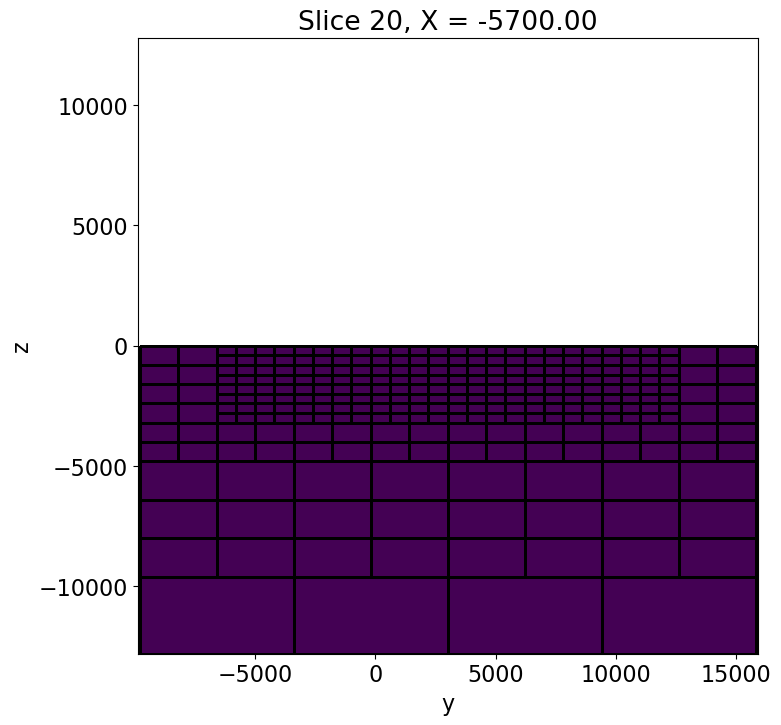

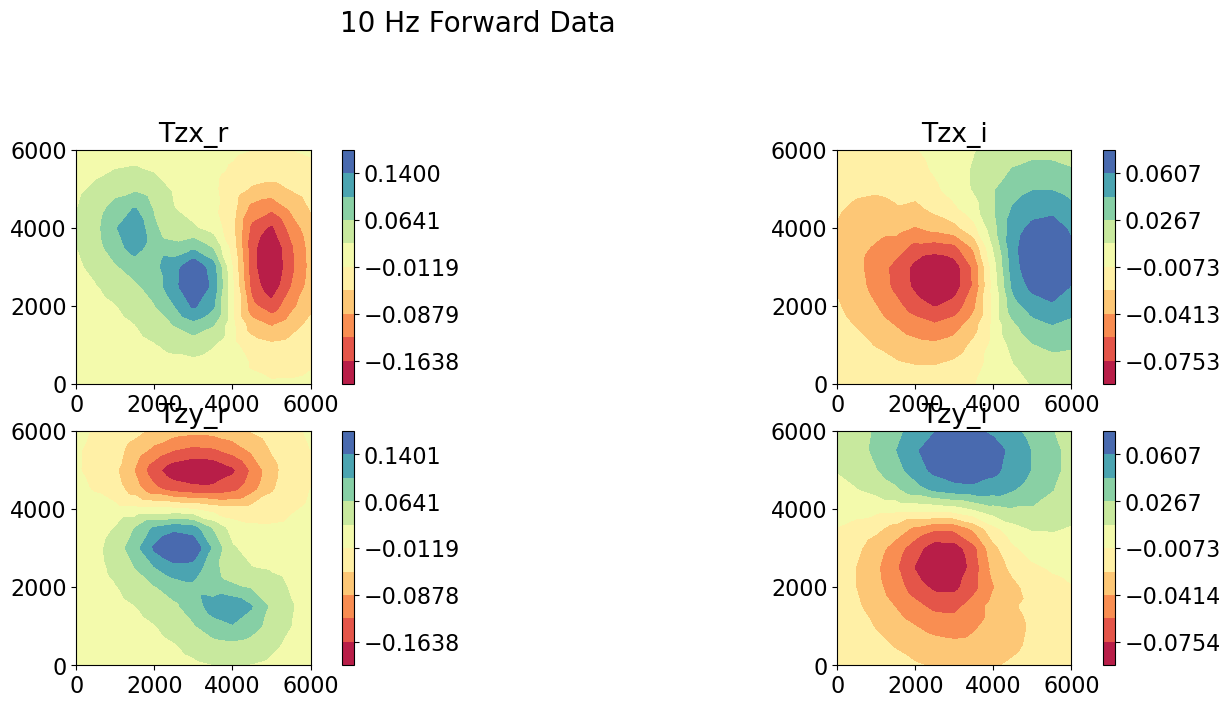

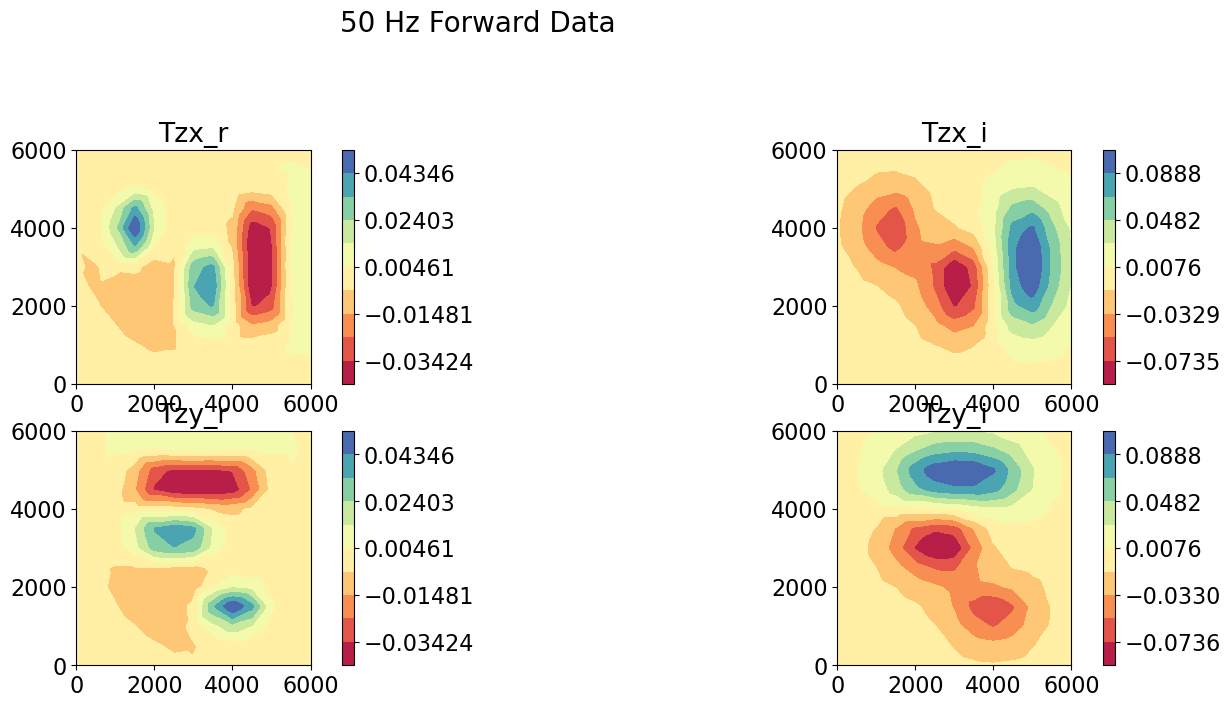

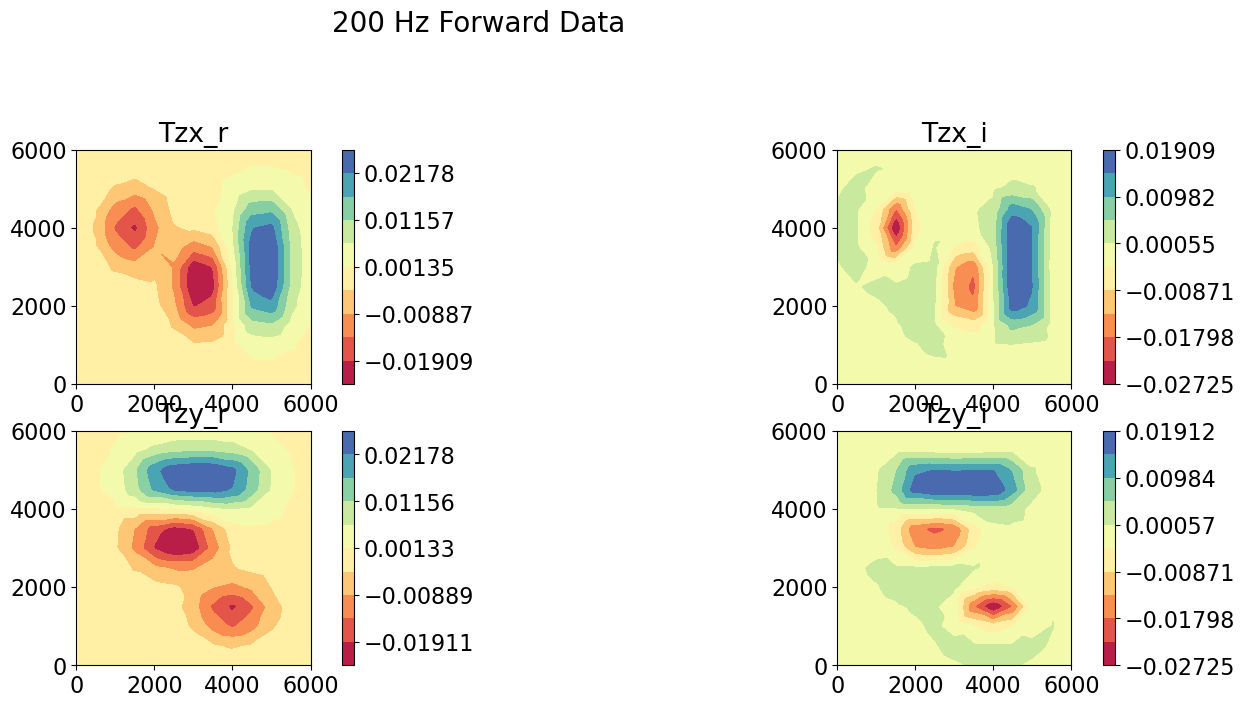

[0.00103239 0.00102858 0.00500256] (2028,)


In [7]:
print(survey.dobs)
# Assign uncertainties
std = 0.05  # 5% std
sim.survey.std = np.abs(survey.dobs) * std
# make data object
fwd_data = data.Data(sim.survey)

# reshape data for plotting
print(receivers.shape[0])
num_station = receivers.shape[0]

num_frequencies = len(freqs)

num_sets = int(survey.dobs.shape[0] / len(freqs))
dnew = np.reshape(survey.dobs, (num_frequencies, num_sets))
stdnew = np.reshape(survey.std, (num_frequencies, num_sets))

# do the ubc data
ubc_dnew = np.reshape(ubc_obs, (num_frequencies, num_sets))

cnt = 0

profile_data = {

    '10':{

    'real': [],
    'imag': []

    },

    '50':{

    'real': [],
    'imag': []

    },

    '200':{

    'real': [],
    'imag': []

    }
}

ubc_profile_data = {

    '10':{

    'real': [],
    'imag': []

    },

    '50':{

    'real': [],
    'imag': []

    },

    '200':{

    'real': [],
    'imag': []

    }
}

profile_data_i = {

    '10':{

    'real': [],
    'imag': []

    },

    '50':{

    'real': [],
    'imag': []

    },

    '200':{

    'real': [],
    'imag': []

    }
}

ubc_profile_data_i = {

    '10':{

    'real': [],
    'imag': []

    },

    '50':{

    'real': [],
    'imag': []

    },

    '200':{

    'real': [],
    'imag': []

    }
}


for freq in freqs:
    cnt_comp = 0
    # comps_ = ['rho_xy', 'phi_xy', 'rho_yx', 'phi_yx']
    comps_ = ['Tzx_r', 'Tzx_i', 'Tzy_r', 'Tzy_i']
    fig1 = plt.figure(figsize=(18, 14))
    for rx_orientation in range(len(comps_)):
        pert = 1e-2
        pert_diag = 1e-3  #np.percentile(np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)]), 10)
        
        if comps_[rx_orientation][-2:] == 'xx':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.1) + pert
        
        elif comps_[rx_orientation][-2:] == 'yy':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.1) + pert
        
        elif freq == '200':
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.05) + 0.005
        
        else:
#             print(pert_diag)
            stdnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] = np.abs(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)] * 0.05) + pert_diag

        if comps_[rx_orientation] == 'Tzx_r':
            # print(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)].shape)
            profile_data[freq]['real'].append(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            ubc_profile_data[freq]['real'].append(ubc_dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
        
        elif comps_[rx_orientation] == 'Tzx_i':
            profile_data[freq]['imag'].append(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            ubc_profile_data[freq]['imag'].append(ubc_dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])

        elif comps_[rx_orientation] == 'Tzy_r':
            # print(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)].shape)
            profile_data_i[freq]['real'].append(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            ubc_profile_data_i[freq]['real'].append(ubc_dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
        
        elif comps_[rx_orientation] == 'Tzy_i':
            profile_data_i[freq]['imag'].append(dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            ubc_profile_data_i[freq]['imag'].append(ubc_dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)])
            
        ax = plt.subplot(4,2, cnt_comp + 1)
        im = utils.plot_utils.plot2Ddata(receivers, dnew[cnt, num_station*rx_orientation:num_station*(rx_orientation + 1)], ax=ax, contourOpts={'cmap':'Spectral'})
        ax.set_title(comps_[rx_orientation])
        plt.colorbar(im[0])
        cnt_comp += 1
    cnt += 1
    fig1.suptitle(freq + ' Hz Forward Data', fontsize='20')
plt.show()
print(mkvc(stdnew)[:3], stdnew.flatten('F').shape)

## Plotting figures

(13,) 10 91
(13,) 50 91
(13,) 200 91
(13,) 10 91
(13,) 50 91
(13,) 200 91
[ 6.58486810e-06 -4.34553125e-05  2.73904472e-06 ... -2.40419995e-12
 -1.38307970e-12 -7.70279413e-13]


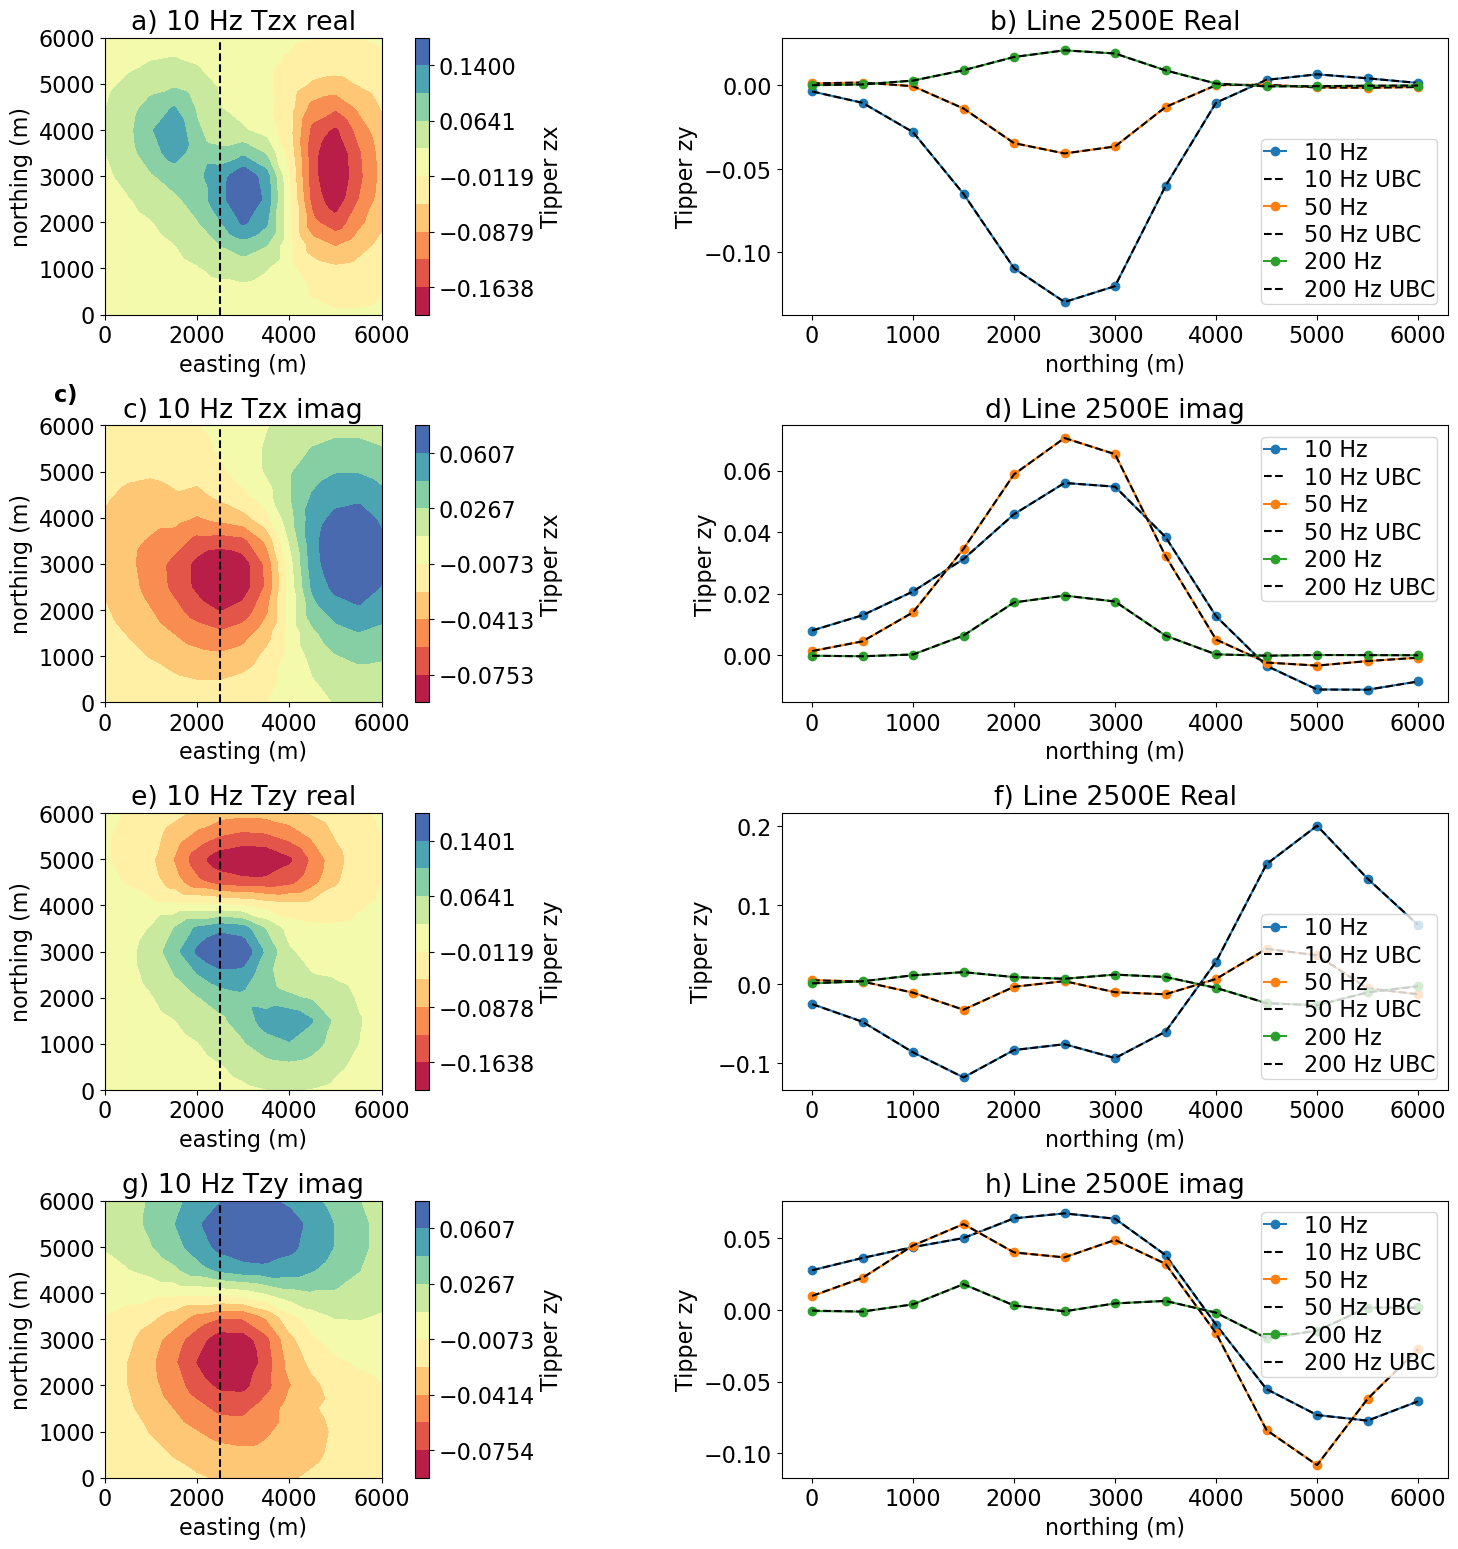

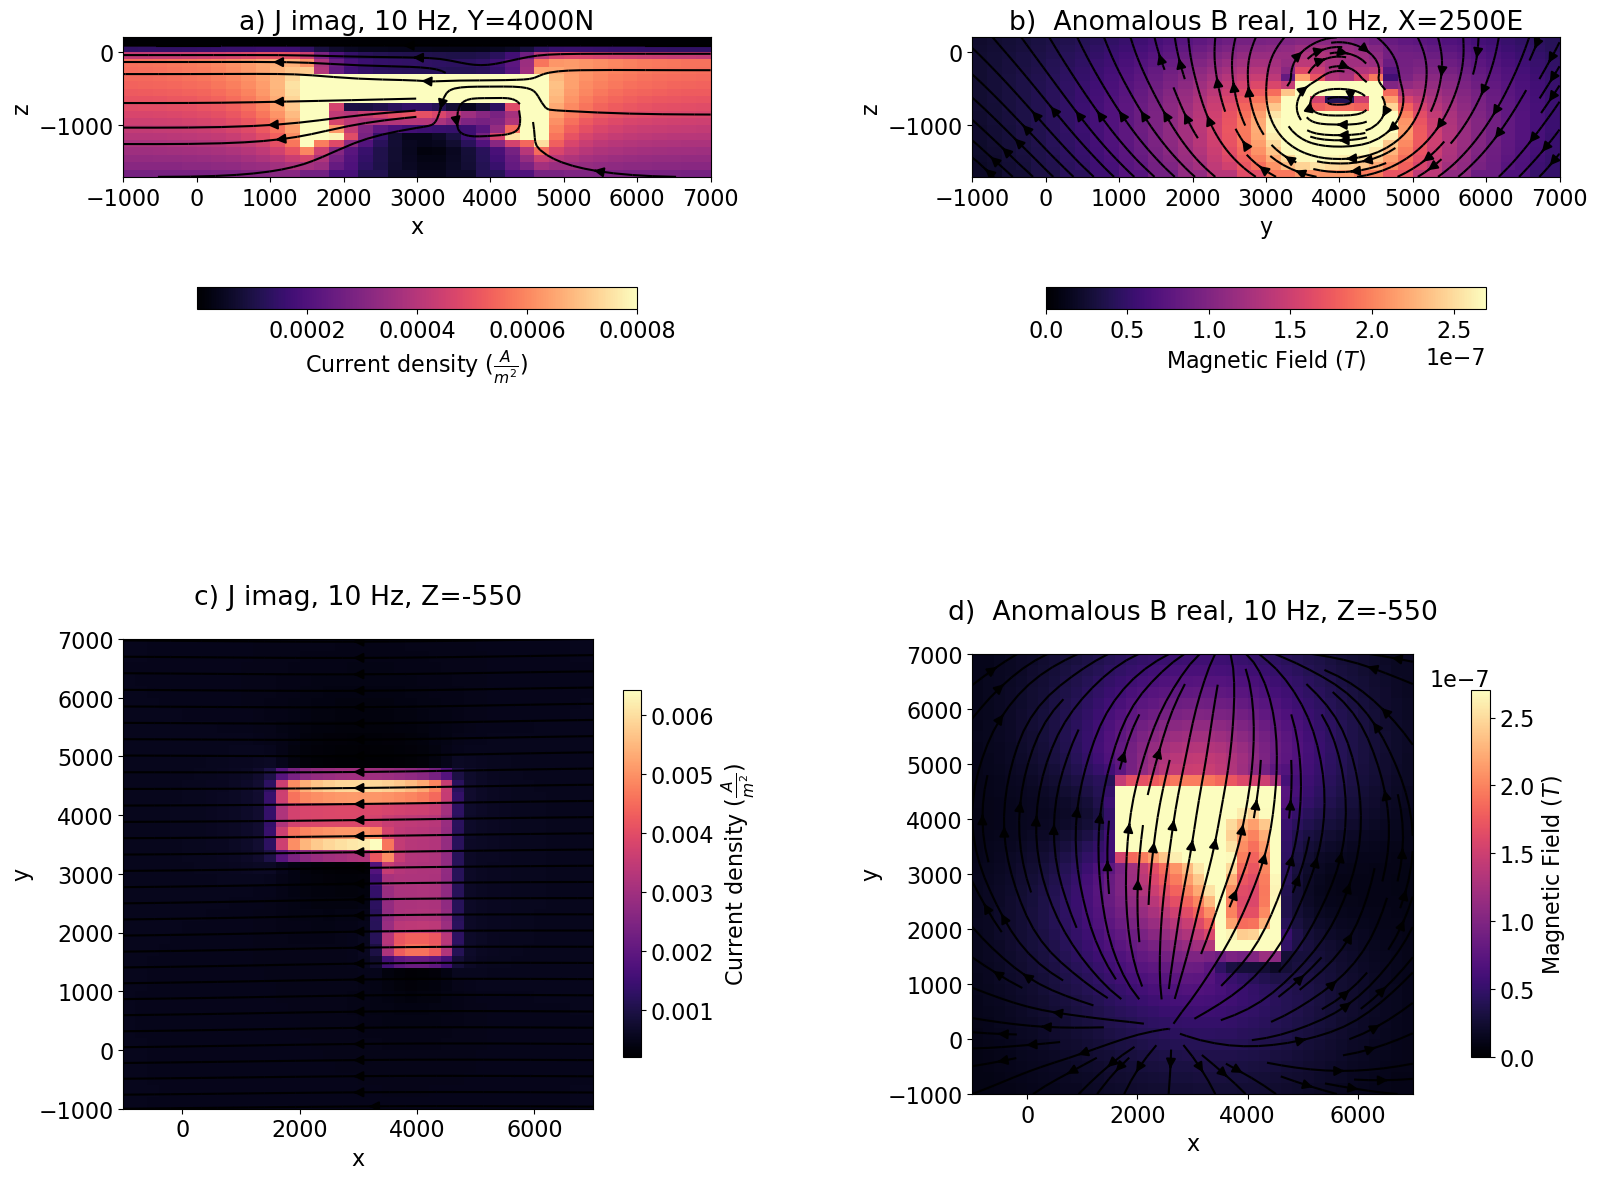

[3500.    0.   50.]


In [11]:
from tree_plot import streamplot_tree
from matplotlib.colors import LogNorm, Normalize
import matplotlib
font = {
        'size'   : 16}
matplotlib.rcParams.update(matplotlib.rcParamsDefault)
matplotlib.rc('font', **font)

def streamplot_tree(
    mesh, data, normal='y', slice_location='C', range_x1=None, range_x2=None,
    nx1=128, nx2=128, ax=None, pcolor_opts=None, streamplot_opts=None, ind=66
):
    if ax is None:
        ax = plt.gca()
    normal = normal.lower()
    if range_x1 is None:
        if normal == 'x':
            range_x1 = mesh.nodes_y[[0, -1]]
        else:
            range_x1 = mesh.nodes_x[[0, -1]]
    if range_x2 is None:
        if normal == 'z':
            range_x2 = mesh.nodes_y[[0, -1]]
        else:
            range_x2 = mesh.nodes_z[[0, -1]]
    
    if slice_location == 'C':
        nodes = getattr(mesh, f'nodes_{normal}')
        slice_location = 0.5*(mesh.nodes_x[0] + mesh.nodes_x[-1])
    
    grid_x1 = np.linspace(*range_x1, nx1)
    grid_x2 = np.linspace(*range_x2, nx2)
    X1, X2, X3 = np.meshgrid(grid_x1, grid_x2, [slice_location])
    if normal == 'x':
        stack = [X3, X1, X2]
    elif normal == 'y':
        stack = [X1, X3, X2]
    else:
        stack = [X1, X2, X3]
    slice_grid = np.stack(stack, axis=-1).reshape((-1, 3))
    X1 = X1[..., 0]
    X2 = X2[..., 0]
    X3 = X3[..., 0]
    
    if len(data) == mesh.n_faces:
        d_type = 'faces'
    else:
        d_type = 'edges'
        
    if normal != 'y':
        # then need y component
        interp = mesh.get_interpolation_matrix(slice_grid, d_type+"_y")
        dat_y = interp @ data
    else:
        dat_y = None
    if normal != 'x':
        # then need x component
        interp = mesh.get_interpolation_matrix(slice_grid, d_type+"_x")
        dat_x = interp @ data
    else:
        dat_x = None
    if normal != 'z':
        # then need z component
        interp = mesh.get_interpolation_matrix(slice_grid, d_type+"_z")
        dat_z = interp @ data
    
    if normal == 'x':
        dat = [dat_y.reshape(X1.shape), dat_z.reshape(X1.shape)]
    elif normal == 'y':
        dat = [dat_x.reshape(X1.shape), dat_z.reshape(X1.shape)]
    else:
        dat = [dat_x.reshape(X1.shape), dat_y.reshape(X1.shape)]
    dat_cc = getattr(mesh, f'average_{d_type[:-1]}_to_cell_vector') @ data
    dat_cc = dat_cc.reshape((-1, 3), order='F')
    dat_norm = np.linalg.norm(dat_cc, axis=-1)
        
    if pcolor_opts is None:
        pcolor_opts = {}
    if streamplot_opts is None:
        streamplot_opts = {}
    
    im0, = mesh.plot_slice(
        dat_norm, v_type='CC', normal=normal, ax=ax, ind=ind, range_x=range_x1, range_y=range_x2, pcolor_opts=pcolor_opts
    )
    im1 = ax.streamplot(X1, X2, *dat, **streamplot_opts)
    return im0, im1

# ---------------------------------------------------------------------------------------------------------------------------

# plot the profile subplots

#

# data_dict = fwd_data

# print(fields, rx_list[:2])

# lets plot some plots
fig, ax = plt.subplots(4, 2, figsize=(20, 18))
idx = 7

for key in profile_data.keys():
    print(profile_data[key]['real'][0][(13*8):(13*8 + 13)].shape, key, 13*idx)
    ax[0, 1].plot(np.arange(0, 6500, 500), -profile_data[key]['real'][0][(13*idx):(13*idx + 13)], 'o-', label=f"{key} Hz")
    ax[0, 1].plot(np.arange(0, 6500, 500), ubc_profile_data[key]['real'][0][(13*idx):(13*idx + 13)], '--k', label=f"{key} Hz UBC")
    ax[1, 1].plot(np.arange(0, 6500, 500), -profile_data[key]['imag'][0][(13*idx):(13*idx + 13)], 'o-', label=f"{key} Hz")
    ax[1, 1].plot(np.arange(0, 6500, 500), ubc_profile_data[key]['imag'][0][(13*idx):(13*idx + 13)], '--k', label=f"{key} Hz UBC")

ax[0, 1].legend(loc='lower right',handlelength=1, borderpad=0.1, labelspacing=0.2)
ax[0, 1].set_title('b) Line 2500E Real')
ax[0, 1].set_xlabel('northing (m)')
ax[0, 1].set_ylabel('Tipper zy')
ax[1, 1].set_title('d) Line 2500E imag')
ax[1, 1].set_xlabel('northing (m)')
ax[1, 1].set_ylabel('Tipper zy')
ax[1, 1].legend(loc='upper right',handlelength=1, borderpad=0.1, labelspacing=0.2)

for key in profile_data_i.keys():
    print(profile_data[key]['real'][0][(13*8):(13*8 + 13)].shape, key, 13*idx)
    ax[2, 1].plot(np.arange(0, 6500, 500), -profile_data_i[key]['real'][0][(13*idx):(13*idx + 13)], 'o-', label=f"{key} Hz")
    ax[2, 1].plot(np.arange(0, 6500, 500), ubc_profile_data_i[key]['real'][0][(13*idx):(13*idx + 13)], '--k', label=f"{key} Hz UBC")
    ax[3, 1].plot(np.arange(0, 6500, 500), -profile_data_i[key]['imag'][0][(13*idx):(13*idx + 13)], 'o-', label=f"{key} Hz")
    ax[3, 1].plot(np.arange(0, 6500, 500), ubc_profile_data_i[key]['imag'][0][(13*idx):(13*idx + 13)], '--k', label=f"{key} Hz UBC")

ax[2, 1].legend(loc='lower right',handlelength=1, borderpad=0.1, labelspacing=0.2)
ax[2, 1].set_title('f) Line 2500E Real')
ax[2, 1].set_xlabel('northing (m)')
ax[2, 1].set_ylabel('Tipper zy')
ax[3, 1].set_title('h) Line 2500E imag')
ax[3, 1].set_xlabel('northing (m)')
ax[3, 1].set_ylabel('Tipper zy')
ax[3, 1].legend(loc='upper right',handlelength=1, borderpad=0.1, labelspacing=0.2)


# ---------------------------------------------------------------------------------------------------------------------------

# plot the plan-map subplots

#

key = "10"
im = utils.plot_utils.plot2Ddata(receivers, profile_data[key]['real'][0], ax=ax[0, 0], contourOpts={'cmap':'Spectral'})
ax[0, 0].plot([2500,2500], [0, 6000], '--k')
ax[0, 0].set_title(f"a) {key} Hz Tzx real")
ax[0, 0].set_xlabel('easting (m)')
ax[0, 0].set_ylabel('northing (m)')
plt.colorbar(im[0], label=r'Tipper zx')

# ax[1, 0].text(-0.1, 1.15, 'c)', transform=ax[1, 0].transAxes,
#       fontsize=16, fontweight='bold', va='top', ha='right')

im = utils.plot_utils.plot2Ddata(receivers, profile_data[key]['imag'][0], ax=ax[1, 0], contourOpts={'cmap':'Spectral'})
ax[1, 0].plot([2500,2500], [0, 6000], '--k')
ax[1, 0].set_title(f"c) {key} Hz Tzx imag")
ax[1, 0].set_xlabel('easting (m)')
ax[1, 0].set_ylabel('northing (m)')
plt.colorbar(im[0], label=r'Tipper zx')

# now imaginary
im = utils.plot_utils.plot2Ddata(receivers, profile_data_i[key]['real'][0], ax=ax[2, 0], contourOpts={'cmap':'Spectral'})
ax[2, 0].plot([2500,2500], [0, 6000], '--k')
ax[2, 0].set_title(f"e) {key} Hz Tzy real")
ax[2, 0].set_xlabel('easting (m)')
ax[2, 0].set_ylabel('northing (m)')
plt.colorbar(im[0], label=r'Tipper zy')

ax[1, 0].text(-0.1, 1.15, 'c)', transform=ax[1, 0].transAxes,
      fontsize=16, fontweight='bold', va='top', ha='right')

im = utils.plot_utils.plot2Ddata(receivers, profile_data_i[key]['imag'][0], ax=ax[3, 0], contourOpts={'cmap':'Spectral'})
ax[3, 0].plot([2500,2500], [0, 6000], '--k')
ax[3, 0].set_title(f"g) {key} Hz Tzy imag")
ax[3, 0].set_xlabel('easting (m)')
ax[3, 0].set_ylabel('northing (m)')
plt.colorbar(im[0], label=r'Tipper zy')

plt.subplots_adjust(left=0.1,
                    bottom=0.1,
                    right=0.9,
                    top=0.9,
                    wspace=0.4,
                    hspace=0.4)

# plt.show()

# ---------------------------------------------------------------------------------------------------------------------------

# plot the slice of currents and B-field subplots

#

fig, ax = plt.subplots(2, 2, figsize=(18, 18))

frequencies = [10, 50, 200]

xlim = np.r_[-1000, 7000]
ylim = np.r_[-1700, 200]

key = "L_block"
src_ind = 0

out = streamplot_tree(
    mesh,
    fields[key][source_list[src_ind], "j"][:, 0].imag, normal="Y", ax=ax[0, 0],
    pcolor_opts={"norm": Normalize(vmax=8e-4), "cmap": 'magma'},
    streamplot_opts={'density':0.6 ,'color': 'black', 'minlength': 0.5, 'arrowsize':1.4}, range_x1=xlim, range_x2=ylim, ind=int(69)
)
plt.colorbar(out[0], ax=ax[0, 0], shrink=0.75, label=r'Current density ($\frac{A}{m^2}$)', orientation='horizontal')
# ax[0, 0].set_xlim(xlim)
# ax[0, 0].set_ylim(ylim)
ax[0, 0].set_title(f"a) J imag, {frequencies[src_ind]} Hz, Y=4000N")
ax[0, 0].set_aspect(1)

print(fields[key][source_list[src_ind], "j"][:, 0].imag)
out = streamplot_tree(
    mesh,
    fields[key][source_list[src_ind], "j"][:, 0].imag, normal="Z", ax=ax[1, 0],
    pcolor_opts={"cmap": 'magma'},
    streamplot_opts={'color': 'black', 'arrowsize':1.4},range_x1=xlim, range_x2=xlim,
    ind=int(122)
)
plt.colorbar(out[0], ax=ax[1, 0], shrink=0.5, label=r'Current density ($\frac{A}{m^2}$)')
# ax[0, 0].set_xlim(xlim)
# ax[0, 0].set_ylim(ylim)
ax[1, 0].set_title(f"c) J imag, {frequencies[src_ind]} Hz, Z=-550", pad=25)
ax[1, 0].set_aspect(1)

# plt.show()
# key = "L_block"
# src_ind = 0
subtract = "half_space" 

plotme = fields[key][source_list[src_ind], "b"][:, 0].real
if subtract is not None:
    plotme = plotme - fields[subtract][source_list[src_ind], "b"][:, 0].real

out = streamplot_tree(
    mesh,
    plotme, normal="X", ax=ax[0, 1],
    pcolor_opts={"norm": Normalize(vmin=0, vmax=2.7e-7), "cmap": 'magma'}, #LogNorm(vmin=3e-11, vmax=1e-7)},
    streamplot_opts={'color': 'black', 'arrowsize':1.4},
    range_x1=xlim, range_x2=ylim,
    ind=int(61)
)
plt.colorbar(out[0], ax=ax[0, 1], shrink=0.75, label=r'Magnetic Field ($T$)', orientation='horizontal')

ax[0, 1].set_title(f"b)  Anomalous B real, {frequencies[src_ind]} Hz, X=2500E")
ax[0, 1].set_aspect(1)

out = streamplot_tree(
    mesh,
    plotme, normal="Z", ax=ax[1, 1],
    pcolor_opts={"norm": Normalize(vmin=0, vmax=2.7e-7), "cmap": 'magma'}, #LogNorm(vmin=3e-11, vmax=1e-7)},
    streamplot_opts={'color': 'black', 'arrowsize':1.4},
    range_x1=xlim, range_x2=xlim,
    ind=int(122)
)
plt.colorbar(out[0], ax=ax[1, 1], shrink=0.5, pad=0.1, label=r'Magnetic Field ($T$)')

ax[1, 1].set_title(f"d)  Anomalous B real, {frequencies[src_ind]} Hz, Z=-550", pad=25)
ax[1, 1].set_aspect(1)

fig.tight_layout(pad=5.0)

plt.show()
# ax[2].set_xlabel("x (m)")
print(receivers[13*idx, :])

## Save fields

In [169]:
# save the fields 

directory = '.'
# key = 'L_block'
for key in fields.keys():

    for ii in range(3):

        freq = frequencies[ii]

        np.save(f"{directory}/fields_{key}_{freq}", fields[key][source_list[ii], :]['eSolution'])

print("saved")

saved
